In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchmetrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

2024-04-30 16:19:05.566312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 16:19:06.678506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, target):
        self.data = torch.tensor(df, dtype=torch.float32).unsqueeze(1) # unsqueeze to add channel dimension
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 100
experiment_name = 'lucas_01'
print('device:', device)

device: cuda


In [5]:
df_train = pd.read_csv('data/lucas_dataset_train.csv')
df_val = pd.read_csv('data/lucas_dataset_val.csv')
df_test = pd.read_csv('data/lucas_dataset_test.csv')

In [6]:
print(df_train.shape)
df_train

(13939, 4216)


,Unnamed: 0,spc.400,spc.400.5,spc.401,spc.401.5,spc.402,spc.402.5,spc.403,spc.403.5,spc.404,...,sand,pH.in.CaCl2,pH.in.H2O,OC,CaCO3,N,P,K,CEC,set
0,5671,0.669077,0.676745,0.684369,0.691928,0.699396,0.706758,0.713992,0.721079,0.728002,...,75,4.78,5.15,8.2,0,0.9,39.6,54.6,2.8,2
1,9008,0.679681,0.687950,0.696161,0.704279,0.712283,0.720136,0.727818,0.735309,0.742584,...,41,4.33,4.84,44.1,0,2.5,54.2,261.8,13.8,1
2,9941,0.786848,0.795459,0.804018,0.812496,0.820865,0.829104,0.837181,0.845079,0.852777,...,48,6.08,6.67,22.6,0,2.3,29.1,216.5,12.8,1
3,345,0.583825,0.592186,0.600491,0.608715,0.616834,0.624822,0.632655,0.640310,0.647767,...,35,4.67,5.58,21.0,0,1.5,0.0,69.8,4.7,1
4,4307,0.791126,0.799194,0.807208,0.815131,0.822943,0.830612,0.838116,0.845435,0.852549,...,50,6.77,7.04,38.8,6,3.0,12.1,54.3,20.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13934,8155,0.642357,0.650594,0.658771,0.666853,0.674813,0.682620,0.690251,0.697683,0.704898,...,86,3.72,4.66,10.3,0,0.3,15.5,21.0,3.0,3
13935,1636,0.922261,0.934263,0.946202,0.958037,0.969738,0.981275,0.992614,1.003729,1.014598,...,22,7.01,7.69,11.3,2,1.0,0.0,458.5,22.6,3
13936,5012,0.705685,0.712331,0.718935,0.725476,0.731939,0.738299,0.744541,0.750645,0.756600,...,89,3.09,3.95,9.3,0,0.4,0.0,20.3,4.7,1
13937,3820,0.821155,0.831790,0.842372,0.852866,0.863251,0.873497,0.883579,0.893470,0.903146,...,53,7.02,7.68,6.2,1,0.7,0.0,466.0,17.1,1


### Get X and y of train and val

In [7]:
# Logical array of columns
input_cols = df_train.columns.str.contains('spc') | df_train.columns.str.contains('GPS')
drop_cols = ['Unnamed: 0', 'set']

X_train = df_train[df_train.columns[input_cols]]
y_train = df_train[df_train.columns[~input_cols]].drop(drop_cols, axis=1)
X_val = df_val[df_val.columns[input_cols]]
y_val = df_val[df_val.columns[~input_cols]].drop(drop_cols, axis=1)
X_test = df_test[df_val.columns[input_cols]]
y_test = df_test[df_val.columns[~input_cols]].drop(drop_cols, axis=1)

nr_output_features = y_train.shape[1]
nr_input_features = X_train.shape[1]
print('nr_output_features:', nr_output_features, '\nnr_input_features:', nr_input_features)

nr_output_features: 12 
nr_input_features: 4202


### Scale X and y

In [8]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

### Load train and validation dataset

In [19]:
train_ds = Dataset(X_train, y_train)
val_ds = Dataset(X_val, y_val)
test_ds = Dataset(X_test, y_test)

nr_features = len(train_ds)
nr_features

13939

In [10]:
# get first item
inp, out = val_ds.__getitem__(100)
# print shapes
print(inp.shape)
print(out.shape)

torch.Size([1, 4202])
torch.Size([12])


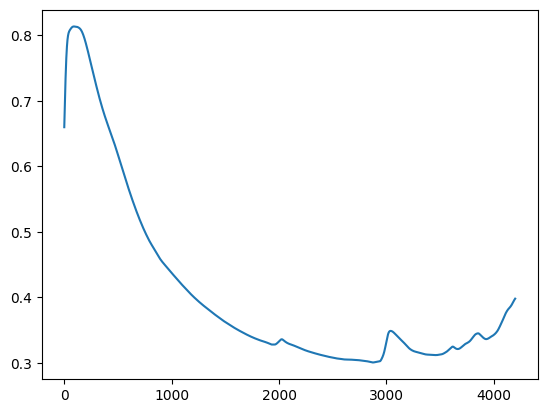

In [11]:
# plot first sample
plt.plot(X_scaler.inverse_transform(inp)[0, :-2])
plt.show()

### Create train and validation dataloader

In [21]:
# create train dataloader
trainloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch_size,
    drop_last = True,
    shuffle = True,
    num_workers = 8
)
# create validation dataloader
valloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False,
    num_workers = 8
)
testloader = torch.utils.data.DataLoader(
    test_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False,
    num_workers = 8
)

### Define network

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),       # 4202 -> 2101
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),      # 2101 -> 1051
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),      # 1051 -> 526
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),     # 526 -> 263
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),    # 263 -> 132
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),    # 132 -> 66
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1),   # 66 -> 33
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
        )

        self.features2 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),       # 4202 -> 4202
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),      # 4202 -> 4202
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 4202 -> 2101

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),      # 2101 -> 2101
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),     # 2101 -> 2101
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 2101 -> 1051
            
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),    # 263 -> 132
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),    # 132 -> 66
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            
            nn.Conv1d(512, 1024, kernel_size=3, stride=1, padding=1),   # 66 -> 33
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 33, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(512, 64),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(64, 12),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): L

In [14]:
from torchsummary import summary
summary(net, (1, 4202))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 2101]              64
       BatchNorm1d-2             [-1, 16, 2101]              32
         LeakyReLU-3             [-1, 16, 2101]               0
            Conv1d-4             [-1, 32, 1051]           1,568
       BatchNorm1d-5             [-1, 32, 1051]              64
         LeakyReLU-6             [-1, 32, 1051]               0
            Conv1d-7              [-1, 64, 526]           6,208
       BatchNorm1d-8              [-1, 64, 526]             128
         LeakyReLU-9              [-1, 64, 526]               0
           Conv1d-10             [-1, 128, 263]          24,704
      BatchNorm1d-11             [-1, 128, 263]             256
        LeakyReLU-12             [-1, 128, 263]               0
           Conv1d-13             [-1, 256, 132]          98,560
      BatchNorm1d-14             [-1, 2

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [15]:
import torch.optim as optim  # Optimization algorithms for training the model
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 50  # Number of training epochs
# criterion = F.mse_loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.0005)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler

### Define train and validate function

In [29]:
def train(net, train_loader, verbose=False):
    net.train()
    running_loss = 0.0
    for inputs, gt in train_loader:
        inputs = inputs.to(device)
        gt = gt.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.mse_loss(outputs, gt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

def validate(net, val_loader, verbose=False):
    net.eval()
    val_loss = 0
    losses = []
    for inputs, gt in val_loader:
        inputs = inputs.to(device)
        gt = gt.to(device)

        with torch.no_grad():
            out = net(inputs)
            loss = F.mse_loss(out, gt)
            val_loss += loss.item()
            losses.append(loss.item())
    if verbose:
        print(f'Loss: {np.mean(losses):.4f}, std: {np.std(losses):.4f}, min: {np.min(losses):.4f}, max: {np.max(losses):.4f}')

    return val_loss / len(val_loader)

def exit_condition(best_value, running_loss, val_loss, epoch, no_improv):
    if best_value is None or running_loss < best_value:
        best_value = running_loss
        torch.save(net.state_dict(), f'./models/{experiment_name}.pth')
        no_improv = 0

    # Early stopping due to overfitting
    if running_loss < val_loss * 0.9 and epoch > 20:
        print('Early stopping due to overfitting')
        return True
    if running_loss > best_value:
        no_improv += 1
        if no_improv > 10:
            print('Early stopping due to no improvement')
            return True

### Perform training with fine-tuning

In [17]:
best_value = None
no_improv = 0
try:
    pbar.close()
except:
    pass

pbar = tqdm(total=epochs, desc='Training', leave=True) # Progress bar for training

for epoch in range(epochs):

    running_loss = train(net, trainloader)

    val_loss = validate(net, valloader)

    writer.add_scalar('Epoch', epoch, epoch)
    writer.add_scalars('Loss/epoch', {'train': running_loss, 'val': val_loss}, epoch)

    pbar.set_description(f'Training - Loss: {running_loss:.4f} - Val Loss: {val_loss:.4f} \nBest loss: {best_value:.4f} - Nr epochs no improvement: {no_improv}')

    if exit_condition(best_value=best_value, running_loss=running_loss, val_loss=val_loss, epoch=epoch, no_improv=no_improv):
        break

    pbar.update(1)

pbar.close()
writer.close()

Training - Loss: 0.465110 - Val Loss: 0.376777: 100%|██████████| 50/50 [03:14<00:00,  3.89s/it]


### Test on test data

In [30]:
test_loss = validate(net, testloader, verbose=True)

Loss: 0.4016, std: 0.0956, min: 0.2791, max: 0.6766
